## Shap on mnist

### Install package and download dataset

In [1]:
# install shap package
!pip install shap

In [25]:
import shap
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms

In [5]:
train_dataset= datasets.MNIST(root= 'mnist_data', train= True, download= True, transform= transforms.Compose([transforms.ToTensor()]))
valid_dataset= datasets.MNIST(root= 'mnist_data', train= False, download= True, transform= transforms.Compose([transforms.ToTensor()]))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5031453.61it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 152019.72it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1244629.15it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2353079.15it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [6]:
train_loader= torch.utils.data.DataLoader(dataset= train_dataset,
                                         batch_size= 128,
                                         shuffle= True)
valid_loader= torch.utils.data.DataLoader(dataset= valid_dataset,
                                         batch_size= 128,
                                         shuffle= True)

### Defining and training model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cv= nn.Sequential(nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= 3, stride= 1, padding= 1), 
                               nn.ReLU(), 
                               nn.MaxPool2d(kernel_size= 2, stride= 2),
                               nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, stride= 1, padding= 1),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size= 2, stride= 2)
                              )
        self.fc= nn.Sequential(nn.Flatten(),
                              nn.Linear(32* 7* 7, 128),
                              nn.ReLU(),
                              nn.Linear(128, 10))
    def forward(self, x):
        return self.fc(self.cv(x))

In [7]:
net= Net()
num_epoch= 10
loss_fn= nn.functional.cross_entropy
optimizer= torch.optim.Adam(net.parameters(), lr= 1e-3)
device= torch.device('cuda:0' if torch.cuda.is_available()== 'cuda' else 'cpu')
# train
def train(model, device, data_loader, optimizer, epoch, loss_fn):
    model.train()
    loss_conter, corr_conter= [], []
    for i, (data, label) in enumerate(data_loader):
        data, label= data.to(device), label.to(device)
        pred= model(data)
        corr_conter.append((pred.argmax(1)== label).sum()/ data.shape[0])
        loss= loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_conter.append(loss.item())
    print(f'epcoh: {epoch+ 1}, loss: {torch.tensor(loss_conter).mean()}, acc: {torch.tensor(corr_conter).mean()}')
# valid
def valid(model, device, data_loader, epoch, loss_fn):
    model.eval()
    loss_conter, corr_conter= [], []
    with torch.no_grad():
        for data, label in data_loader:
            data, label= data.to(device), label.to(device)
            pred= model(data)
            corr_conter.append((pred.argmax(1)== label).sum()/ data.shape[0])
            loss= loss_fn(pred, label)
            loss_conter.append(loss.item())
    avg_loss, avg_corr= torch.tensor(loss_conter).mean(), torch.tensor(corr_conter).mean()
    print(f'valid. epoch: {epoch+ 1}, loss: {avg_loss}, acc: {avg_corr}')
    return avg_loss, avg_corr

In [8]:
# train model and save best model
best_corr= -1
for i in range(num_epoch):
    train(net, device, train_loader, optimizer, i, loss_fn)
    loss, corr= valid(net, device, valid_loader, i, loss_fn)
    if corr> best_corr:
        best_corr= corr
        torch.save({'net_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': i+ 1
                   }, 'checkpoint.pth')
# load best model
checkpoint= torch.load('checkpoint.pth')
net.load_state_dict(checkpoint['net_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epcoh: 1, loss: 0.3247753977775574, acc: 0.9040122628211975
valid. epoch: 1, loss: 0.09671562910079956, acc: 0.9701344966888428
epcoh: 2, loss: 0.08218581229448318, acc: 0.9756352305412292
valid. epoch: 2, loss: 0.06144169345498085, acc: 0.9804192781448364
epcoh: 3, loss: 0.05601190775632858, acc: 0.9825316071510315
valid. epoch: 3, loss: 0.05111858621239662, acc: 0.9822982549667358
epcoh: 4, loss: 0.04318106919527054, acc: 0.9867460131645203
valid. epoch: 4, loss: 0.040312521159648895, acc: 0.9864517450332642
epcoh: 5, loss: 0.03492630273103714, acc: 0.9889448285102844
valid. epoch: 5, loss: 0.03366124629974365, acc: 0.9886273741722107
epcoh: 6, loss: 0.028004994615912437, acc: 0.9914045929908752
valid. epoch: 6, loss: 0.02755201980471611, acc: 0.9902096390724182
epcoh: 7, loss: 0.023719094693660736, acc: 0.9923818111419678
valid. epoch: 7, loss: 0.027240457013249397, acc: 0.9903085231781006
epcoh: 8, loss: 0.019132893532514572, acc: 0.994003176689148
valid. epoch: 8, loss: 0.03192329

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


### Explain behavior of model

In [39]:
images, labels= next(iter(valid_loader))
background= images[ :124]
test_images= images[124:]
exper= shap.DeepExplainer(net, background)
shap_vales= exper.shap_values(test_images)
# shap_vales[i], explanation of the classification of models into category i.
print(f'len of shap_vales: {len(shap_vales)}, shape of shap_vales[0]: {shap_vales[0].shape}')

unrecognized nn.Module: Flatten


len of shap_vales: 10, shape of shap_vales[0]: (4, 1, 28, 28)


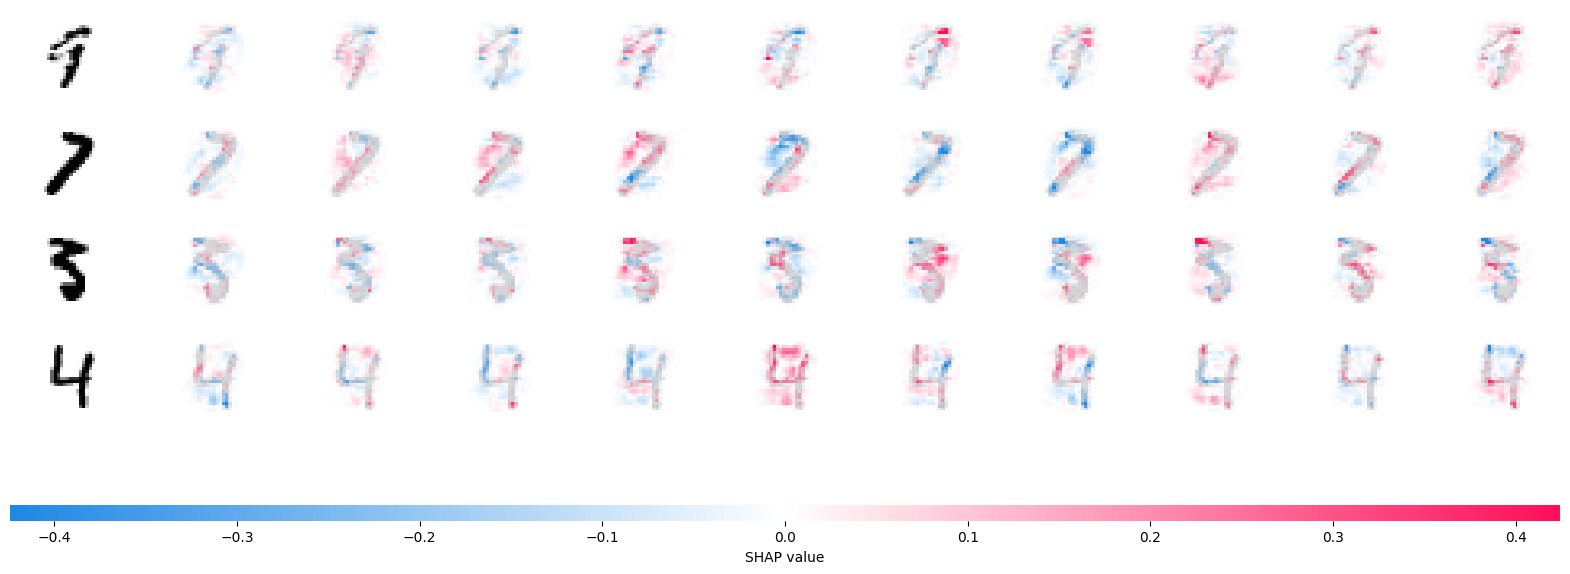

In [40]:
# view
test_images= torch.permute(test_images, (0, 2, 3, 1))
shap_vales= [np.transpose(s, (0, 2, 3, 1)) for s in shap_vales]
shap.image_plot(shap_vales, -test_images.numpy())

## shap on uci heart disease dataset

### load dataset and import package

In [53]:
# copy data
cp /kaggle/input/heart-disease-data/heart_disease_uci.csv /kaggle/working/UCI_data/heart_disease_uci.csv

In [122]:
import shap
shap.initjs()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### data preprocess

In [89]:
heart_disease_uci= pd.read_csv('UCI_data/heart_disease_uci.csv')
heart_disease_uci= heart_disease_uci.drop(['id', 'dataset'], axis= 1)
# apply function on column 'num'
heart_disease_uci['num']= heart_disease_uci['num'].apply(lambda x: 1 if x!= 0 else 0)
# cholesterol, 胆固醇; fasting_blood_sugar, 空腹时是否血糖高; rest_ecg, 静息时心电图特征; angina, 心绞痛; st_depression, 心电图中ST段压低; st_slope, 心电图中ST波峰值的坡度;
# num_major_vessel, 心脏附近主血管数目; thalassemia, 是否患有地中海贫血症; target, 是否心脏病;
heart_disease_uci.columns= ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar',
                           'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels',
                           'thalassemia', 'target']
# convert to dummies
heart_disease_uci= pd.get_dummies(heart_disease_uci)
heart_disease_uci= heart_disease_uci.dropna()

In [131]:
heart_disease_uci

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_Female,sex_Male,chest_pain_type_asymptomatic,...,rest_ecg_normal,rest_ecg_st-t abnormality,exercise_induced_angina_False,exercise_induced_angina_True,st_slope_downsloping,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145.0,233.0,150.0,2.3,0.0,0,False,True,False,...,False,False,True,False,True,False,False,True,False,False
1,67,160.0,286.0,108.0,1.5,3.0,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
2,67,120.0,229.0,129.0,2.6,2.0,1,False,True,True,...,False,False,False,True,False,True,False,False,False,True
3,37,130.0,250.0,187.0,3.5,0.0,0,False,True,False,...,True,False,True,False,True,False,False,False,True,False
4,41,130.0,204.0,172.0,1.4,0.0,0,True,False,False,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,60,130.0,0.0,130.0,1.1,1.0,1,False,True,True,...,False,True,False,True,True,False,False,False,False,False
691,62,120.0,0.0,134.0,-0.8,2.0,1,False,True,False,...,False,False,True,False,False,True,False,False,False,False
717,72,160.0,0.0,114.0,1.6,2.0,0,False,True,False,...,False,False,True,False,False,True,False,False,False,False
748,56,120.0,100.0,120.0,1.5,0.0,1,False,True,True,...,True,False,False,True,False,True,False,False,False,True


### fit model

In [94]:
# split dataset
X= heart_disease_uci.drop('target', axis= 1)
y= heart_disease_uci['target']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 1206)
# train model
model= DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

### shap analysis

In [128]:
exper= shap.TreeExplainer(model)
# shap_vales, [The contribution of the features of each instance to predicting class0, The contribution of the features of each instance to predicting class1];
shap_vales= exper.shap_values(X_test)

In [130]:
# visualize a single prediction,
# SHAP force oriented graph, which intuitively displays how the predicted results of a single 
# sample are obtained by the combined contribution of various features.
# expected_value, Traverse all samples in the training set, make predictions for each sample, 
#                 and then add up all predicted values and divide by the number of samples to 
#                 obtain the average predicted value, which is called expected-value.
# shap_vales, The contribution of each feature to the model's prediction results.
shap.force_plot(exper.expected_value[1], shap_vales[1][1, :], X_test.iloc[1, :])

In [138]:
# visualize many predictions
shap.force_plot(exper.expected_value[1], shap_vales[1][:60, :], X_test.iloc[:60, :])

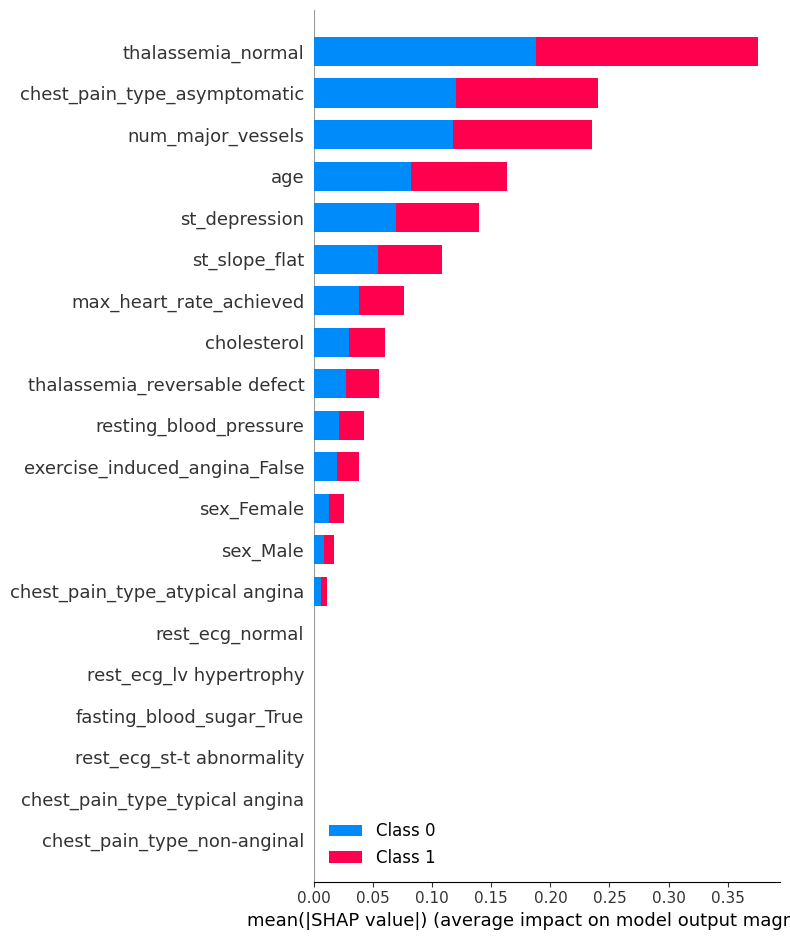

In [139]:
# The behavior of the model on the entire test dataset, as well as the importance and direction of
# influence of each feature on the model output.
shap.summary_plot(shap_vales, X_test)